# Assignment 1 - Simplified Custom Object Detection

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of object detection: -from loading and inspecting the dataset; -to implementing, training and evaluating a Convolutional Neural Network based architecture. The sections are there to guide you but you do not have to follow them strictly.




-**Name:**  Toheed Azmat Butt
-**Neptun ID:** O1RYJ2
-**Network:** Custom Object Detection
-**Objects:** Frog,Man,Teddy

## Task description

Your task is to train your own custom object detection model and compare its performance with an existing object detection model (i.e. YOLO). For that, you need to generate a synthetic dataset to train your own custom model and fine-tune an existing one. This is a simplified version of object detection, where each image must only contain a single object.
There is no expected high performance, but **your metrics should show results better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualizations (matplotlib, seaborn, ...) of the metrics, losses, and predictions. Use techniques to avoid overfitting such as Early stopping, and more, and save the best model while training your network.

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [4]:
# ADD YOUR CODE HERE
import torch
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import datasets, transforms

### 1.1. Load objects

**Please select 3 or more objects.** Upon selecting the objects, **please remove the background, so that only the object is kept**. You can do it manually, online or by code (this is not part of the evaluation of your assignment).
As an example, the following objects have been chosen (the background was removed with Segment Anything Model):

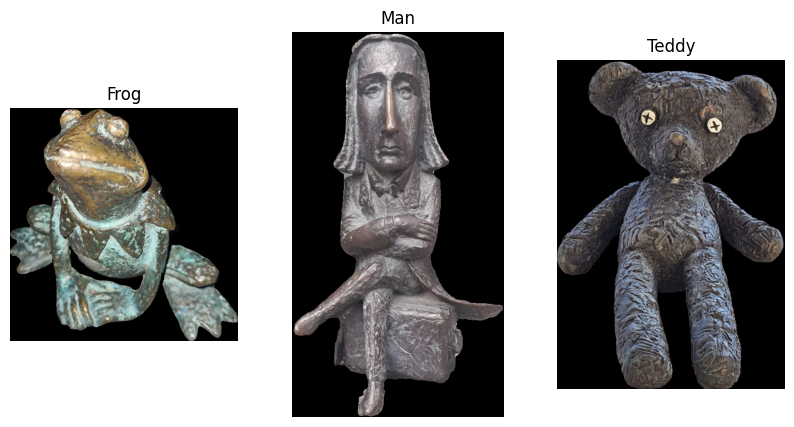

In [5]:
#Normalize data
transform = transforms.Compose([ transforms.ToTensor()])#transforms.Resize((128, 128)),])
#load the dataset
dataset=datasets.ImageFolder(root='Objects', transform=transform)
#creat dataloader
def collate_fn(batch):
    images = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch])
    return images, labels

dataloader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=True, collate_fn=collate_fn)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=True)
#get a batch of images and labels
images, labels = next(iter(dataloader))
#define class names
class_names=['Frog','Man','Teddy']
#plot the images
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
    axes[i].imshow(images[i].permute(1, 2, 0))
    axes[i].set_title(class_names[labels[i]])
    axes[i].axis('off')
plt.show()

In [6]:
for i, image in enumerate(images):
    print(f"Shape of image {i+1}: {image.shape}")


Shape of image 1: torch.Size([3, 658, 646])
Shape of image 2: torch.Size([3, 796, 437])
Shape of image 3: torch.Size([3, 1402, 972])


### 1.2. Load backgrounds

In order to train a custom object detection model, a dataset is needed. For this assignment, a synthetic dataset should be created by:
- Inserting an object in a random position of a background image

We want to follow a similar pattern to what Mihály Kolodko did, by inserting the objects in the streets of Budapest. **Thus, collect a few background images of different locations in Budapest.** This can be done manually or via code. The recommendation is to use icrawler to collect them.

**Sample Images**

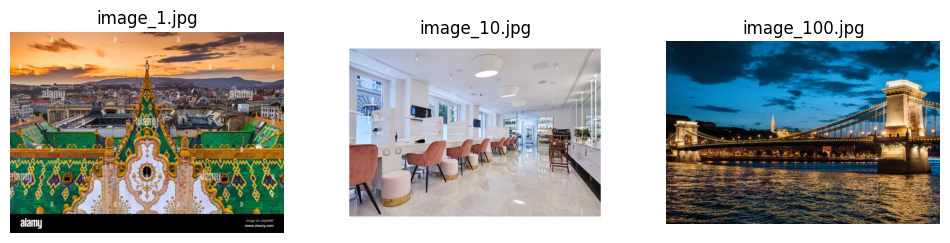

In [7]:
directory = 'background'
#Show some of the images, to confirm that they were successfully crawled
def display_sample_images(directory):
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    for i, filename in enumerate(os.listdir(directory)[:3]):
        image = Image.open(os.path.join(directory, filename))
        axes[i].imshow(image)
        axes[i].set_title(filename)
        axes[i].axis('off')
    plt.show()
display_sample_images(directory)

### 1.3. Create dataset

**Creating Dataset with YOLOV8 format**

In [27]:
import os
import random
from PIL import Image

def createDataset(root_dir, background_dir, split='train', img_size=(640,640), num_images=5000):
    split_dir = os.path.join(root_dir, split)
    images_dir = os.path.join(split_dir, 'images')
    labels_dir = os.path.join(split_dir, 'labels')

    # Create directories if they don't exist
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    background_dir='D:/Assignment 1 dnd/background'

    background_images = os.listdir(background_dir)
    object_dirs = os.listdir('D:/Assignment 1 dnd/Objects')

    # Create a mapping from object names to class indices and sizes
    class_map = {object_name:i for i, object_name in enumerate(object_dirs)}
    size_map={object_name:random.randint(100,150)for object_name in object_dirs}

    for i in range(num_images):
        # Load the background image
     bg_image_path = os.path.join(background_dir, random.choice(background_images))
     bg_image = Image.open(bg_image_path).convert('RGBA').resize(img_size)

     # Randomly select an object directory and object image
     object_dir = random.choice(object_dirs)
     class_index=class_map[object_dir]
     object_size=size_map[object_dir]
     object_image_path = random.choice(os.listdir(os.path.join('D:/Assignment 1 dnd/Objects', object_dir)))
     object_image = Image.open(os.path.join('D:\Assignment 1 dnd\Objects', object_dir, object_image_path)).convert('RGBA').resize((object_size,object_size))

    # Generate random coordinates for the object
     max_x = bg_image.width - object_image.width
     max_y = bg_image.height - object_image.height
     random_x = random.randint(0, max_x)
     random_y = random.randint(0, max_y)

    # Paste the object onto the background image
     bg_image.paste(object_image, (random_x, random_y), object_image)

    # Save the resulting image
     image_filename = f'{i:05d}.png'
     image_path = os.path.join(images_dir, image_filename)
     bg_image.save(image_path)

    
    # Calculate the bounding box coordinates in YOLO format
     bbox_x = (random_x + object_size / 2) / bg_image.width
     bbox_y = (random_y + object_size / 2) / bg_image.height
     bbox_w = object_size / bg_image.width
     bbox_h = object_size / bg_image.height

     label_filename = f'{i:05d}.txt'
     label_path = os.path.join(labels_dir, label_filename)

     with open(label_path, 'w') as f:
        # Extract object name from the folder name
        object_name = os.path.basename(object_dir)
        # Get the class index from the object name
        labels = class_map.get(object_name, -1)  # Use -1 if class not found
        if labels == -1:
            print(f"Warning: Class '{object_name}' not found in class_map.")
        f.write(f'{labels} {bbox_x:.6f} {bbox_y:.6f} {bbox_w:.6f} {bbox_h:.6f}\n')






# Create train, val, and test datasets
createDataset('dataset', 'background', split='train', img_size=(640,640), num_images=578)
createDataset('dataset', 'background', split='val', img_size=(640,640), num_images=200)
createDataset('dataset', 'background', split='test', img_size=(640,640), num_images=48)


**Pytorch Dataset Class**

In [8]:
from PIL import Image
from torchvision.transforms import ToTensor, Compose
from torch.utils.data import Dataset


class ObjectDetectionDataset(Dataset):
    def __init__(self, root_dir, split='train', num_classes=3, transform=None):
        self.root_dir = root_dir
        self.split_dir = os.path.join(root_dir, split)
        self.image_dir = os.path.join(self.split_dir, 'images')
        self.label_dir = os.path.join(self.split_dir, 'labels')
        self.image_filenames = sorted(os.listdir(self.image_dir))
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace('.png', '.txt'))

        # Load image
        image = Image.open(img_path).convert('RGBA')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Load label
        with open(label_path, 'r') as f:
            bbox_list = []
            for line in f:
                label = line.strip().split()
                labels = int(label[0])
                bbox = [float(x) for x in label[1:]]  # Extract bounding box coordinates
                bbox_list.append(bbox)

        return image, torch.tensor(labels), torch.tensor(bbox_list)


**Data Loaders**

In [9]:
from torch.utils.data import DataLoader
root_dir = 'dataset'
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create train dataset and data loader
train_dataset = ObjectDetectionDataset(root_dir, split='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)

# Create validation dataset and data loader
val_dataset = ObjectDetectionDataset(root_dir, split='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

# Create test dataset and data loader
test_dataset = ObjectDetectionDataset(root_dir, split='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)


**Visualize Data**

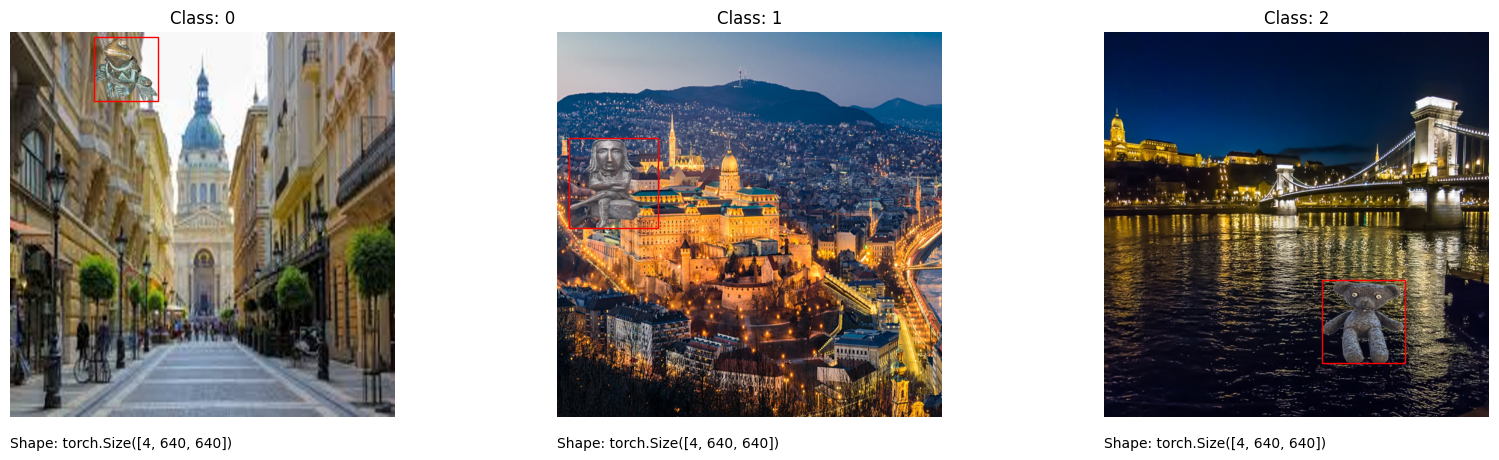

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def visualize_dataset(dataset, num_sample=3):
    fig, axes = plt.subplots(1, num_sample, figsize=(20, 5))
    random_indices = random.sample(range(len(dataset)), num_sample)
    for i, idx in enumerate(random_indices):
        image, labels, bbox_list = dataset[idx]
        axes[i].imshow(image.permute(1, 2, 0))

        # Create a rectangle patch for each bounding box
        for bbox_item in bbox_list:
            bbox_x, bbox_y, bbox_w, bbox_h = bbox_item.tolist()
            bbox_x *= image.shape[2]
            bbox_y *= image.shape[1]
            bbox_w *= image.shape[2]
            bbox_h *= image.shape[1]
            rect = patches.Rectangle((bbox_x - bbox_w / 2, bbox_y - bbox_h / 2), bbox_w, bbox_h, linewidth=1, edgecolor='r', facecolor='none')
            axes[i].add_patch(rect)

        axes[i].set_title(f'Class: {labels}')
        axes[i].axis('off')  # Turn off axis

        # Display image shape below the image
        axes[i].text(0, image.shape[1] + 50, f'Shape: {image.shape}', fontsize=10, color='black')

    plt.show()

visualize_dataset(train_dataset)


# 2. MODELS
For this assignment, you are required to create your own custom object detection model and compare its performance with an existing object detection model.

### 2.1. Custom Object Detection model

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


**Custom Model**

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomModel, self).__init__()

        self.backbone=nn.Sequential(
            nn.Conv2d(4,16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(512,1024,kernel_size=3,stride=1,padding=1), 
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            
        )
        # Detection layers
        self.flatten = nn.Flatten()
        self.classification = nn.Sequential(
            nn.Linear(1024*5*5, 256),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
        self.bbox_regression = nn.Sequential(
            nn.Linear(1024*5*5, 256),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        features = self.backbone(x)
        features = features.view(features.size(0), -1)

        class_probs = self.classification(features)
        bbox_regression = self.bbox_regression(features)
        return class_probs, bbox_regression


In [16]:
dummy_image = torch.randn(1, 4, 640, 640).to(device)
num_classes = 3
dummy_image.shape

model = CustomModel(num_classes).to(device)
class_probs, bbox_regression = model(dummy_image)

print("Class Output Shape:", class_probs.shape)
print("Bounding Box Output Shape:", bbox_regression.shape)


Class Output Shape: torch.Size([1, 3])
Bounding Box Output Shape: torch.Size([1, 4])


### 2.2. Train your model


In [17]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import torch.nn as nn

**Training**

Epoch [1/10], Train Loss: 9.3006, Classification Loss: 7.9674, Regression Loss: 1.3332, Val Loss: 1.5276
Epoch [2/10], Train Loss: 2.1972, Classification Loss: 2.1397, Regression Loss: 0.0574, Val Loss: 1.1383
Epoch [3/10], Train Loss: 1.1415, Classification Loss: 1.1070, Regression Loss: 0.0344, Val Loss: 1.1236
Epoch [4/10], Train Loss: 1.1284, Classification Loss: 1.1016, Regression Loss: 0.0268, Val Loss: 1.1198
Epoch [5/10], Train Loss: 1.1456, Classification Loss: 1.1239, Regression Loss: 0.0217, Val Loss: 1.1188
Epoch [6/10], Train Loss: 1.1412, Classification Loss: 1.1058, Regression Loss: 0.0354, Val Loss: 1.1134
Epoch [7/10], Train Loss: 1.1907, Classification Loss: 1.1730, Regression Loss: 0.0177, Val Loss: 1.1142
Epoch [8/10], Train Loss: 1.1144, Classification Loss: 1.0987, Regression Loss: 0.0157, Val Loss: 1.1136
Epoch [9/10], Train Loss: 1.1130, Classification Loss: 1.0985, Regression Loss: 0.0145, Val Loss: 1.1125
Epoch [10/10], Train Loss: 1.1142, Classification Loss:

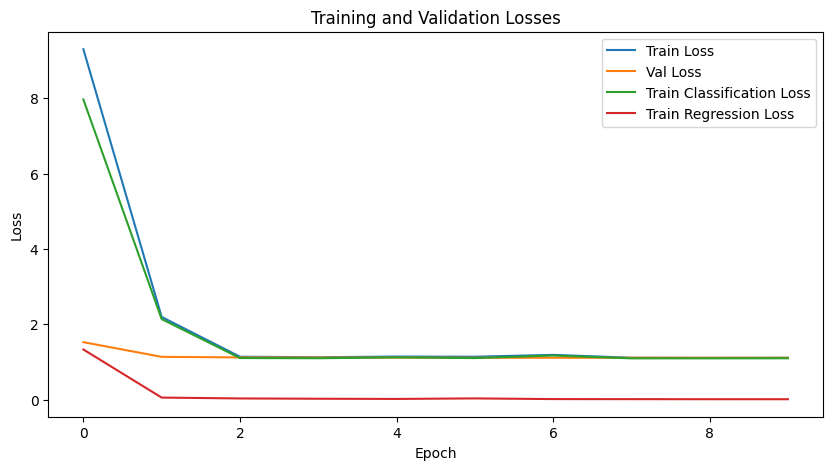

Training complete.


In [19]:
import matplotlib.pyplot as plt

def train(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Define optimizer and parameters
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.005,patience=2)
    
    
    # Define learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3)

    # Define loss functions
    classification_criterion = nn.CrossEntropyLoss()
    regression_criterion = nn.SmoothL1Loss()
    
    train_losses = []
    val_losses = []
    train_classification_losses = []
    train_regression_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_classification_loss = 0.0
        train_regression_loss = 0.0
        
        for image, labels, bbox_list in train_loader:
            image = image.to(device)
            labels = labels.to(device)
            bbox_list = bbox_list.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            class_probs, bbox_regression = model(image)
            
            # Calculate classification loss
            classification_loss = classification_criterion(class_probs, labels)
            
            # Remove extra dimension from bbox_list if present
            bbox_list = torch.squeeze(bbox_list, dim=1)
            
            # Calculate regression loss
            regression_loss = regression_criterion(bbox_regression, bbox_list)
            
            # Total loss
            loss = classification_loss + regression_loss
            
            # Backward pass and optimization
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
            
            train_loss += loss.item() * image.size(0)
            train_classification_loss += classification_loss.item() * image.size(0)
            train_regression_loss += regression_loss.item() * image.size(0)
        
        # Calculate average train loss
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_classification_loss = train_classification_loss / len(train_loader.dataset)
        train_classification_losses.append(train_classification_loss)
        train_regression_loss = train_regression_loss / len(train_loader.dataset)
        train_regression_losses.append(train_regression_loss)
        
        # Validation part
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for image, labels, bbox_list in val_loader:
                image = image.to(device)
                labels = labels.to(device)
                bbox_list = bbox_list.to(device)
                
                # Forward pass
                class_probs, bbox_regression = model(image)
                
                # Calculate classification loss
                classification_loss = classification_criterion(class_probs, labels)
                
                # Remove extra dimension from bbox_list if present
                bbox_list = torch.squeeze(bbox_list, dim=1)
                
                # Calculate regression loss
                regression_loss = regression_criterion(bbox_regression, bbox_list)
                
                # Total loss
                loss = classification_loss + regression_loss
                
                val_loss += loss.item() * image.size(0)
        
        # Calculate average validation loss
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, '
              f'Classification Loss: {train_classification_loss:.4f}, '
              f'Regression Loss: {train_regression_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}')
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
    
    
    # Plot the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.plot(train_classification_losses, label='Train Classification Loss')
    plt.plot(train_regression_losses, label='Train Regression Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()
    
    print('Training complete.')
    
    return model, train_losses, val_losses


model = CustomModel(num_classes=3)  
trained_model, train_losses, val_losses = train(model, train_loader, val_loader, num_epochs=10)


### 2.3. Evaulate and do inference with the trained custom model

Choose at least 3 metrics to evaluate your model (i.e. Precision, Recall, F-1, mean Average Precision, ...). Additionally, you can check the: inference speed, number of parameters, model size, etc.

Show performance metric visualizations.

Show some predictions of your trained model.

**Precision, Recall and mAP**

In [71]:
from sklearn.metrics import precision_score, recall_score, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

def evaluate_test_set(model, test_loader,device):
    model.eval()
    all_predictions = []
    all_targets = []
    all_bbox_preds = []
    all_bbox_targets = []
    with torch.no_grad():
        for image, labels, bbox_list in test_loader:
            image = image.to(device)
            labels = labels.to(device)
            bbox_list = bbox_list.to(device)
            class_probs, bbox_regression = model(image)
            _, predicted = torch.max(class_probs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            all_bbox_preds.extend(bbox_regression.cpu().numpy())
            all_bbox_targets.extend(bbox_list.cpu().numpy())
    precision = precision_score(all_targets, all_predictions, average='macro', zero_division=1)
    recall = recall_score(all_targets, all_predictions, average='macro')
    all_targets_binary = label_binarize(all_targets, classes=np.unique(all_targets))
    all_predictions_binary = label_binarize(all_predictions, classes=np.unique(all_predictions))
    mAP = roc_auc_score(all_targets_binary, all_predictions_binary, average='macro', multi_class='ovr')
    return precision, recall, mAP

precision, recall, mAP = evaluate_test_set(trained_model, test_loader, device)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, mAP: {mAP:.4f}')

C:\Users\Toheed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\linear.py:116: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ..\aten\src\ATen\Context.cpp:164.)
  return F.linear(input, self.weight, self.bias)


Precision: 0.7634, Recall: 0.3333, mAP: 0.5000


***Visualize some test***

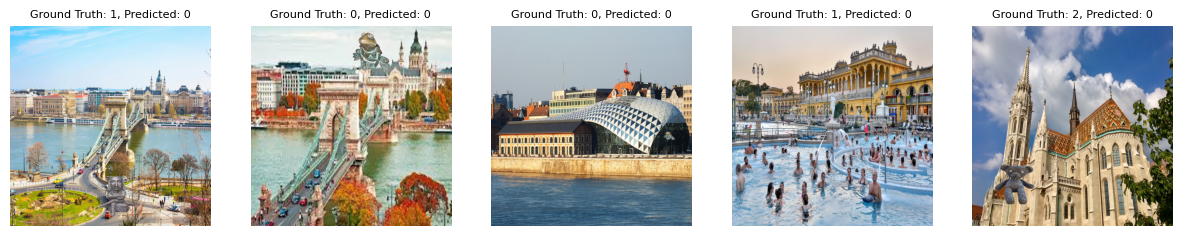

In [62]:
import matplotlib.pyplot as plt

def visualize_predictions(model, test_dataset, num_samples=5, title_fontsize=10, axis_fontsize=8):
    # Set model to evaluation mode
    model.eval()
    
    # Get test dataset loader
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=num_samples, shuffle=True)
    
    # Get a batch of samples from the test dataset
    images, labels, _ = next(iter(test_loader))
    
    # Move images to device
    device = next(model.parameters()).device
    images = images.to(device)
    
    # Forward pass to get predictions
    with torch.no_grad():
        class_probs,_ = model(images)
    
    # Convert predicted class probabilities to class labels
    _, predicted_labels = torch.max(class_probs, 1)
    
    # Plot the images along with their ground truth and predicted labels
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0))  # Convert image to numpy format
        plt.title(f'Ground Truth: {labels[i]}, Predicted: {predicted_labels[i]}', fontsize=title_fontsize)
        plt.axis('off')
        plt.tick_params(axis='both', which='both', labelsize=axis_fontsize)
    plt.show()

# Visualize predictions with smaller text size
visualize_predictions(trained_model, test_dataset, title_fontsize=8, axis_fontsize=6)


### 2.4. Load an existing object detection model
**YOLO**

In [ ]:
%pip install ultralytics

In [5]:
cuda = torch.cuda.is_available()
print(f"CUDA is available: {cuda}")

CUDA is available: True


In [64]:
# ADD YOUR CODE HERE

import torch
from ultralytics import YOLO

ymodel= YOLO('yolov8s.pt')

### 2.5. Fine-tune the existing object detection model
**YOLOV8**

In [65]:

result = ymodel.train(data='D:/Assignment 1 dnd/data.yaml', epochs=10, batch=16, patience=3, weight_decay=0.0005, project='D:/Assignment 1 dnd/YOLOresults', name='train')


Ultralytics YOLOv8.2.2  Python-3.10.11 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=D:/Assignment 1 dnd/data.yaml, epochs=10, time=None, patience=3, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=D:/Assignment 1 dnd/YOLOresults, name=train24, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sav

C:\Users\Toheed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-21 19:03:51,251	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-21 19:03:51,865	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

C:\Users\Toheed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ultralytics\utils\torch_utils.py:199: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ..\aten\src\ATen\Context.cpp:164.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
C:\Users\Toheed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ultraly

AMP: checks passed 


train: Scanning D:\Assignment 1 dnd\dataset\train\labels.cache... 578 images, 0 backgrounds, 0 corrupt: 100%|██████████| 578/578 [00:00<?, ?it/s]
val: Scanning D:\Assignment 1 dnd\dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to D:\Assignment 1 dnd\YOLOresults\train24\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to D:\Assignment 1 dnd\YOLOresults\train24
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]C:\Users\Toheed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ultralytics\utils\loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ..\aten\src\ATen\Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       1/10      4.48G     0.5093      2.545     0.9393          2        640: 100%|██████████| 3

                   all        200        200      0.982      0.991      0.992      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]C:\Users\Toheed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ultralytics\utils\loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ..\aten\src\ATen\Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       2/10      4.55G      0.423     0.7147     0.8889          2        640: 100%|██████████| 3

                   all        200        200      0.994          1      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]C:\Users\Toheed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ultralytics\utils\loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ..\aten\src\ATen\Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       3/10      4.73G     0.3754     0.4645     0.8716          2        640: 100%|██████████| 3

                   all        200        200      0.999          1      0.995      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]C:\Users\Toheed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ultralytics\utils\loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ..\aten\src\ATen\Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       4/10      4.72G     0.3822     0.3969      0.881          2        640: 100%|██████████| 3

                   all        200        200      0.989          1      0.995      0.947
EarlyStopping: Training stopped early as no improvement observed in last 3 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



4 epochs completed in 0.023 hours.
Optimizer stripped from D:\Assignment 1 dnd\YOLOresults\train24\weights\last.pt, 22.5MB
Optimizer stripped from D:\Assignment 1 dnd\YOLOresults\train24\weights\best.pt, 22.5MB

Validating D:\Assignment 1 dnd\YOLOresults\train24\weights\best.pt...
Ultralytics YOLOv8.2.2  Python-3.10.11 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)


C:\Users\Toheed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ultralytics\utils\torch_utils.py:199: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ..\aten\src\ATen\Context.cpp:164.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
C:\Users\Toheed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ultraly

Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


                   all        200        200      0.982      0.991      0.992      0.964
                  Frog        200         71      0.986      0.972      0.986      0.941
                   Man        200         59      0.962          1      0.995      0.955
                 Teddy        200         70      0.998          1      0.995      0.995
Speed: 0.3ms preprocess, 4.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to D:\Assignment 1 dnd\YOLOresults\train24


### 2.6 Evaluate the existing object detection model
Use the same metrics chosen on step 2.3.

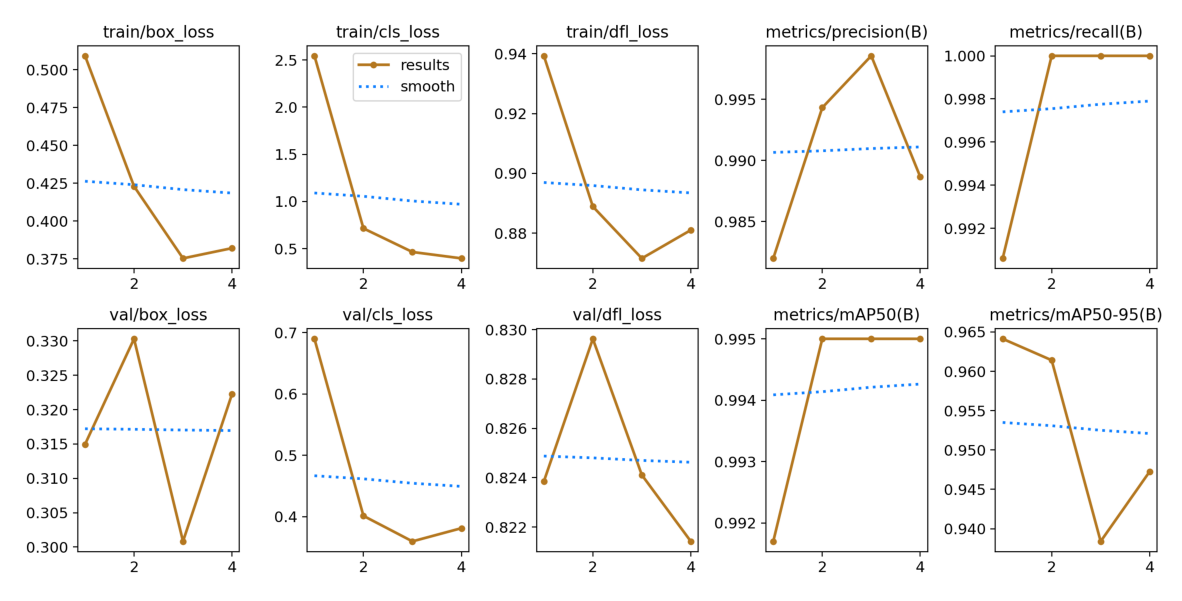

In [66]:
# ADD YOUR CODE HERE
import cv2
import matplotlib.pyplot as plt
img=cv2.imread("YOLOresults/train24/results.png")
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.axis("off")
plt.show()

**Predictions from YOLO**

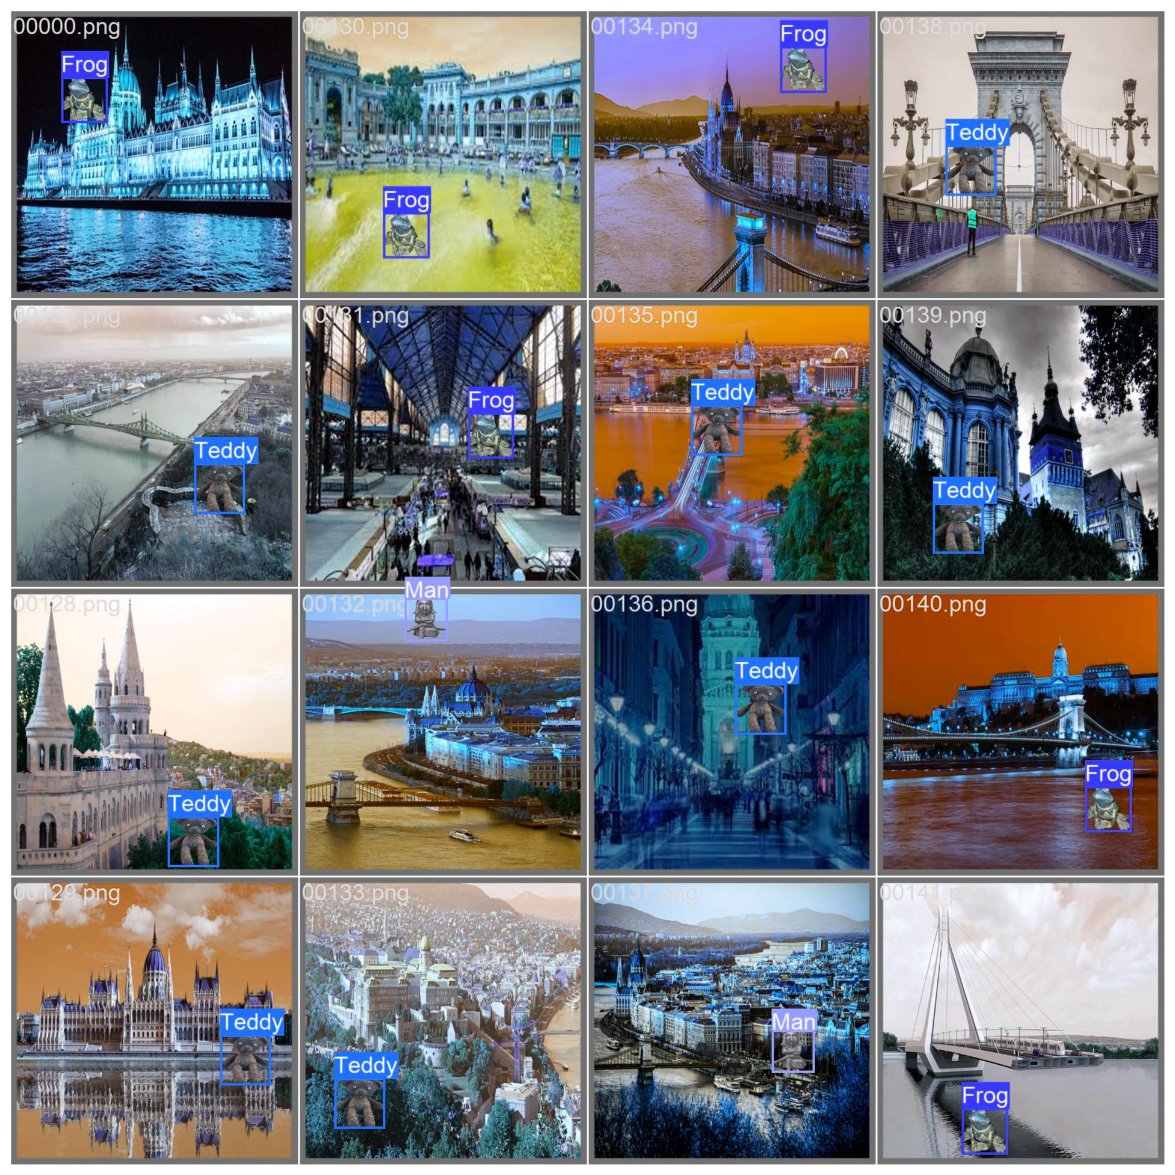

In [67]:
img=cv2.imread("D:/Assignment 1 dnd\YOLOresults/train24/val_batch0_labels.jpg")
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.axis("off")
plt.show()

# 3. COMPARISON

In [68]:
# ADD YOUR CODE HERE

matrices=ymodel.val(data='D:/Assignment 1 dnd/data.yaml')

Ultralytics YOLOv8.2.2  Python-3.10.11 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs


C:\Users\Toheed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ultralytics\utils\torch_utils.py:199: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ..\aten\src\ATen\Context.cpp:164.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
C:\Users\Toheed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ultraly

                   all        124        124        0.8      0.508      0.548      0.441
                  Frog        124         36      0.936      0.444      0.446      0.421
                   Man        124         53      0.465      0.321       0.32      0.267
                 Teddy        124         35          1      0.759      0.878      0.637
Speed: 0.7ms preprocess, 9.3ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to D:\Assignment 1 dnd\YOLOresults\train242


In [69]:
matrices.results_dict

{'metrics/precision(B)': 0.8000658247742497,
 'metrics/recall(B)': 0.5082281382820648,
 'metrics/mAP50(B)': 0.5477968000428298,
 'metrics/mAP50-95(B)': 0.4414975283676752,
 'fitness': 0.4521274555351906}

**Compare**

**CustomModel** 
Precision: 0.7634
Recall: 0.3333
mAP: 0.5000

**Yolov8**
Precision:0.8000
Recall:0.5082
mAP:0.5477

I have done visualization above already for both models. 
First issue that I think is the dataset, I am sure there is something not right with my dataset and I tried a lot but it could be better
I am sure it is something simple but not in front of my eyes.
Recall for both my and yolov8 model are bad while precision is decent which made me believe that the way dataloaders are being handled has some flaws.
Also the fact that validation loss goes down very slowly after a certain point.
Might be some variable issue or something very minor but I tried a lot to debug it but gave up due to time and hardware constraints.
2nd: Issue was with resources from colab to run the model and training properly so I had to run on my local machine.
To accomodate low gpu memory I had to add more layers to the model so that I can run and train it on my machine.
If I could optimize the input and my model more and reduece the layers, I might have been able to get better results.
But again I am sure if I can find the issue with my dataset and dataloaders I can already improve the results by a lot.
Because recall and mAP are low for yolov8 aswell, I am sure it is something with the dataset and dataloaders.

Other than that, data augmentation and regularization techniques can be used to improve the model and results.
I have used dropout and batch normalization but more techniques can be used to improve the model.
I also tried l2 but then dropped it because it was not improving the model.

At the end I would say, there is a lot of margin of improvement with proper dataset and the way dataloaders are being done.
